# Abstract
Today I will be showing my implementation of the logistic regression algorithm, as well as preforming various experiments to demonstrate the machine learning algorithm's characteristics.

In [271]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Link to Source Code
[logistic.py](https://github.com/CameronHudson813/CameronHudson813.github.io/blob/main/posts/Implementing%20Logistic%20Regression/logistic.py)

# Defining Data
Here, we define an assortment of points that will help demonstrate how logistic regression handles classification.

In [272]:
import torch
def generate_classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = generate_classification_data(noise = 0.5)

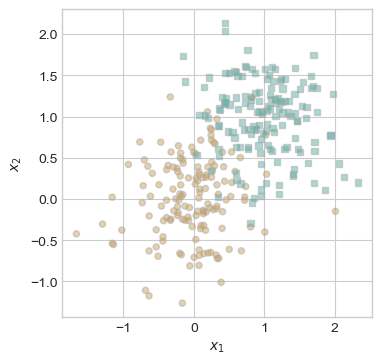

In [273]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_classification_data(X, y, ax)


# Experiments and Demonstrations

# Vanilla Gradient Descent
Within this code, I will demonstrate how the gradient descent alogrithm converges over time to an optimal weight vector `w` that visually seperates a two dimensional dataset where each point belongs to 1 of 2 classes.

In [274]:
# Written by Professor Chodrow
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

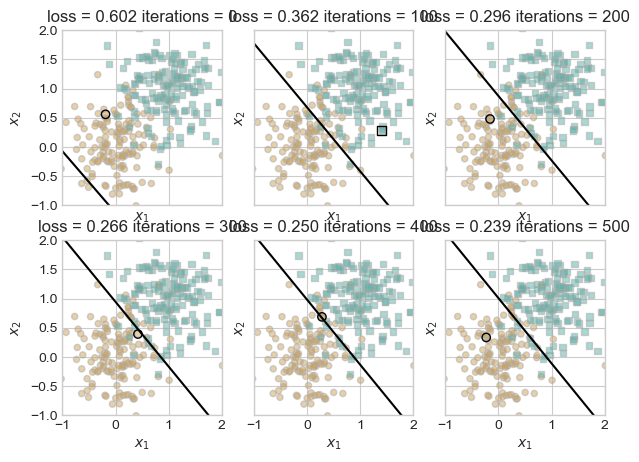

In [275]:
def logistic_regression_fit(X, y, max_iterations, visualize, visual_step, beta):
    # assert ((max_iterations / visual_step == 5) and (visual_step != 0)), "Max_iterations / visual_step must equal 5"
    LR = LogisticRegression() 
    opt = GradientDescentOptimizer(LR)
    LR.loss(X,y)

    plt.rcParams["figure.figsize"] = (7, 5)
    fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
    markers = ["o", ","]
    marker_map = {-1 : 0, 1 : 1}

    current_ax = 0
    n = X.size()[0]

    iterations = 0
    while iterations <= max_iterations:
        ax = axarr.ravel()[current_ax]
        old_w = torch.clone(LR.w)
        i = torch.randint(n, size = (1,))
        x_i = X[[i],:]
        y_i = y[i]

        opt.step(X, y, alpha = 0.1, beta = beta)
        loss = LR.loss(X,y).item()
        if (iterations % visual_step == 0) and visualize:
            plot_classification_data(X,y,ax)
            draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color="black")
            ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
            # draw_line(w, -10, 10, ax, color = "black")
            ax.set_title(f"loss = {loss:.3f} iterations = {iterations}")
            ax.set(xlim = (-1, 2), ylim = (-1, 2))
            current_ax += 1
        iterations+=1 
logistic_regression_fit(X, y, 500, True, 100, 0) 

    

# Benefits of Momentum
Below, we will again call the logistic_regression_fit function, give the function a value of `0.9` for `beta` instead of `0`. This will showcase how a vanilla gradient descent algorithm can converge much quicker due to momentum.
We can see how utilizing momentum in our vanilla gradient descent algorithm can the weight vector `w` coverge to an optimal value much faster. This code demonstrates that while it took vanilla gradient descent `500` iterations to get a loss of `0.239`, it took gradient descent with momentum only `50` iterations to get a similar loss of `0.230`.

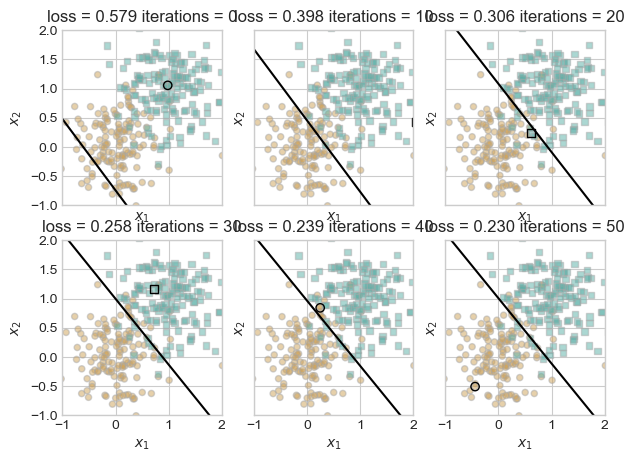

In [276]:
logistic_regression_fit(X, y, 50, True, 10, 0.9) 

# Momentum Experiment Findings
We can see how utilizing momentum in our vanilla gradient descent algorithm can the weight vector `w` coverge to an optimal value much faster. This code demonstrates that while it took vanilla gradient descent `500` iterations to get a loss of `0.221`, it took gradient descent with momentum only `50` iterations to get to an even lower loss of `0.211`.

# Overfitting
We can demonstrate overfitting by creating a dataset with more dimensions that points. In this case, with enough iterations the model will be fit to perfectly capture the training data. This creates 100% training accuracy, but results in low testing accuracy, as the model's predictions are hyper specific to the training data and do not generalize to unseen data. Within this code I demonstrate with two different datasets `X_train`, `y_train`, `X_test`, and `y_test` a 100% training accuracy (`X_train`, `y_train`) and a considerably lower testing accuracy (`X_test`, `y_test`)

In [277]:
X_train, y_train = generate_classification_data(n_points = 50, noise = 0.2, p_dims = 100)
X_test, y_test = generate_classification_data(n_points = 50, noise = 0.2, p_dims = 100)

In [278]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

for _ in range(100):
    # The step at which i fit the model
    opt.step(X_train, y_train, alpha = 0.1, beta = 0.9)

X_train_predictions = LR.predict(X_train)
training_accuracy = (X_train_predictions == y_train).float().mean().item()

X_test_predictions = LR.predict(X_test)
testing_accuracy = (X_test_predictions == y_test).float().mean().item()
print(testing_accuracy)


1.0


In [279]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

for _ in range(1000):
    opt.step(X_train, y_train, alpha = 0.1, beta = 0.9)
print(1-LR.loss(X_train, y_train).item())
print(1-LR.loss(X_test, y_test).item())

0.9984176002908498
0.9930030633695424


# Performance on Empirical Data
We can now test our logistic regression implementation on publicly available supervised classification data. My dataset of choice will be the [Breast Cancer Dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset) created by M Yasser H. Within the dataset is a collection breasts with tumors labeled maligant (`M`) or benign (`B`). The features of the data set are the means of various qualities of the breasts that are predictive of identifying the tumor as being benign or maligant. In order to see these features we must first download the data.

# Downloading Data

In [280]:
import pandas as pd
train = pd.read_csv("breast-cancer.csv")
train.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Processing and Splitting the Data
Now that we have downloaded the data and observed its features, we can now process the data to have it ready to be trained on our logistic regression model. 

In [281]:
from sklearn.model_selection import train_test_split
import numpy as np

def prepare_data(df):
    df = df.dropna()
    y = np.where(df['diagnosis'] == "M", True, False)
    df = df.drop(['diagnosis'], axis = 1)
    df = df.drop(['id'], axis = 1)
    return df, y

X, y = prepare_data(train)

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42)


# Model Training Visualization

In [270]:
def df_to_tensor(df):
    torch_tensor = torch.from_numpy(df.to_numpy())
    torch_tensor = torch.cat((torch_tensor, torch.ones((torch_tensor.shape[0], 1))), 1)
    return torch_tensor.float()
X_train_tensor , y_train_tensor = df_to_tensor(X_train), torch.from_numpy(y_train)
# X_validate_tensor = df_to_tensor(X_validate)
# X_test_tensor = df_to_tensor(X_test)

# train_LR = LogisticRegression() 
# train_opt = GradientDescentOptimizer(train_LR)
# validate_LR = LogisticRegression() 
# validate_opt = GradientDescentOptimizer(validate_LR)

training_loss, training_loss_momentum = [], []
validation_loss, validation_loss_momentum = [], []


# Fitting logistic regression model to training data
# for i in range(100):
#     opt.step(X_train_tensor, y_train, alpha = 0.1, beta = 0)
#     if i % 10 == 0:
#         training_loss.append(LR.loss(X_train_tensor, y_train_tensor).item())
        # training_loss.append(LR.loss(X_validate, y_validate).item())
    # opt.step(X_validate_tensor, y_validate, alpha = 0.1, beta = 0)
# Fitting logistic regression model with momentum on training data
# for i in range(100):
#     opt.step(X_train_tensor, y_train, alpha = 0.1, beta = 0.9)
#     if i % 10 == 0:
#         training_loss.append(LR.loss(X_train_tensor, y_train).item())

